In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import json


In [71]:
# Reading the Dataset

data_file = open('../data/Wiki-Vote.txt', 'r')
lines = data_file.readlines()

In [72]:
#placing the pointer at the start of edge list in the list of lines read from dataset text file
start_ptr = 0
for i in range(len(lines)):
    if(lines[i][0] == '#'):
        start_ptr += 1

In [73]:
#forming the set of NodeID present in the graph
node_set = set()
for i in range(start_ptr, len(lines)):
    split1 = lines[i].split('\t')
    node1 = int(split1[0])
    node2 = int(split1[1][:(len(split1[1]) - 1)])
    node_set.add(node1)
    node_set.add(node2)

In [74]:
num_nodes = len(node_set) #number of nodes

In [75]:
#NodeIDs are not continuous so we assign a unique integer number to each node. The numbers are continuous and in range [0, (number_of_nodes - 1)]
node_num = 0
node_id_to_num = {} #nodeID to node_number mapping [each nodeID is assigned a unique node_number, node_number range from 0 to (number_of_nodes - 1)]
node_num_to_id = {} #node_number to nodeID mapping
for node_id in node_set:
    node_id_to_num[node_id] = node_num
    node_num_to_id[node_num] = node_id
    node_num += 1

Creation of Edge List and Adjacency matrix


In [76]:
edge_list = [] #list of edges
adjacency_matrix = np.zeros((num_nodes, num_nodes)) #adjacency matrix
for i in range(start_ptr, len(lines)): #reading the edges from txt file lines
    split1 = lines[i].split('\t')
    node1_id = int(split1[0]) #nodeID_1 (From NodeID)
    node2_id = int(split1[1][:(len(split1[1]) - 1)]) #nodeID_2 (To NodeID)
    node1_num = node_id_to_num[node1_id] #get node_num for the nodeID
    node2_num = node_id_to_num[node2_id] #get node_num for the nodeID
    edge_list.append([node1_num, node2_num]) #adding edge to edgelist
    adjacency_matrix[node1_num][node2_num] = 1 #[directed graph]

In [77]:
num_edges = len(edge_list) #number of edges

In [78]:
incoming_edges = np.sum(adjacency_matrix, axis=0) #list which has i_th element equal to number of incoming edges to node with node_number i
in_degrees = {node_num:in_deg for node_num, in_deg in enumerate(incoming_edges)} #dictionary of indegree (key=node_num, value=in_degree of tht node)  
outgoing_edges = np.sum(adjacency_matrix, axis=1) #list which has i_th element equal to number of outgoing edges from node with node_number i
out_degrees = {node_num:out_deg for node_num, out_deg in enumerate(outgoing_edges)} #dictionary of outdegree (key=node_num, value=outdegree of that node)

In [79]:
avg_in_degree = np.average(incoming_edges) #average in degree of node
avg_out_degree = np.average(outgoing_edges) #average out degree of node
max_in_degree_node_id = node_num_to_id[max(in_degrees, key= lambda x: in_degrees[x])] #node_id with maximum in-degree
max_in_degree = in_degrees[node_id_to_num[max_in_degree_node_id]] #value of max_in_degree
max_out_degree_node_id = node_num_to_id[max(out_degrees, key= lambda x: out_degrees[x])] #node_id with maximum out-degree
max_out_degree = out_degrees[node_id_to_num[max_out_degree_node_id]] #value of max_out_degree
total_possible_edges = (num_nodes * (num_nodes - 1)) #since its a directed graph, so total number of edges = |V|*(|V|-1); |V|->num_vertices
network_density = num_edges / total_possible_edges #network density is the ratio of number of edges in network to the ratio of total number of edges possible in the network

In [80]:
print("For the network based on chosen dataset :" + "\n" \
    f"-> Number of Nodes  : {num_nodes}" + "\n" \
    f"-> Number of edges  : {num_edges}" + "\n" \
    f"-> Avg. In-Degree   : {avg_in_degree}"+ "\n" \
    f"-> Avg. Out-Degree  : {avg_out_degree}"+ "\n" \
    f"-> Max In-Deg Node  : Node ID - {max_in_degree_node_id} | In-Degree = {max_in_degree}"+ "\n" \
    f"-> Max Out-Deg Node : Node ID - {max_out_degree_node_id} | Out-Degree = {max_out_degree}"+ "\n" \
    f"-> Network Density  : {network_density}")

For the network based on chosen dataset :
-> Number of Nodes  : 7115
-> Number of edges  : 103689
-> Avg. In-Degree   : 14.573295853829936
-> Avg. Out-Degree  : 14.573295853829936
-> Max In-Deg Node  : Node ID - 4037 | In-Degree = 457.0
-> Max Out-Deg Node : Node ID - 2565 | Out-Degree = 893.0
-> Network Density  : 0.0020485375110809584


Local Clustering Coeff

In [81]:
und_adjacency_matrix = np.zeros((num_nodes, num_nodes)) #forming the undirected version of the same graph
for edge in edge_list:
    node1_num = edge[0]
    node2_num = edge[1]
    und_adjacency_matrix[node1_num][node2_num] = 1
    und_adjacency_matrix[node2_num][node1_num] = 1

In [82]:
neighbours = {} #dictionary storing neighbours (directly-connected) of each node
local_clustering_coeff = {} #dictionary storing lcc of each node

for node in tqdm(range(num_nodes)): #iterate over all nodes
    neighbourhood_set = set() #set storing neighbours(directly-connected) of a node
    for j in range(num_nodes):
        if(und_adjacency_matrix[node][j] == 1): #if the node is directly connected
            neighbourhood_set.add(j) #it is a neighbourhood node
    neighbours[node] = neighbourhood_set
    num_neighbours = len(neighbourhood_set)
    # print(f"Node {node} | Neighbours {num_neighbours}")
    num_neighbourhood_links = 0 #number of existing links between neighbourhood nodes
    for neighbour in neighbourhood_set:
        for j in neighbourhood_set:
            if(j != neighbour and und_adjacency_matrix[neighbour][j]): #if edge exists
                num_neighbourhood_links += 1
    # print(f"Node {node} | Neighbours {num_neighbours} | links = {num_neighbourhood_links}")
    num_neighbourhood_links = num_neighbourhood_links / 2 #divdeing by two because we considered undirected version of graph, but in reality, it is directed
    if(num_neighbourhood_links == 0):
        local_clustering_coeff_node = 0
    else:
        local_clustering_coeff_node = num_neighbourhood_links / ((num_neighbours * (num_neighbours - 1)) / 2) #divide by total number of links that can exist possibly
    local_clustering_coeff[node] = local_clustering_coeff_node

with open("lcc.json", "w") as outfile:
    json.dump(local_clustering_coeff, outfile)


100%|██████████| 7115/7115 [00:50<00:00, 139.59it/s]


In [83]:
def plot_distribution(distribution, xlabel, ylabel, title, save=False):
    '''
        Function to plot distributions
    '''
    distribution_sorted = sorted(distribution.items(), key= lambda x:x[0])
    # print(max(distribution_sorted, key=lambda x : x[1]))
    plt_x = [x[0] for x in distribution_sorted]
    plt_y = [y[1] for y in distribution_sorted]
    plt.plot(plt_x, plt_y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if(save == True):
        plt.savefig(f"{title}.png", bbox_inches='tight', facecolor='w')
    plt.show()

In [84]:
in_degree_distribution = dict(Counter(list(in_degrees.values()))) #in-degree distribution (value-frequency type dictionary)
out_degree_distribution = dict(Counter(list(out_degrees.values()))) #out-degree distribution (value-frequency type dictionary)
clustering_coeff_distribution = dict(Counter(list(local_clustering_coeff.values()))) #clustering-coefficient distribution (value-frequency type dictionary)

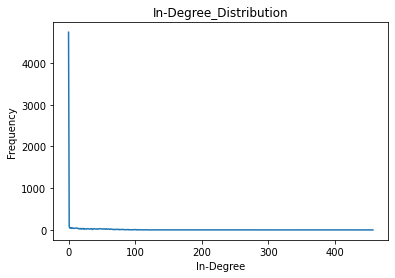

In [85]:
plot_distribution(in_degree_distribution, "In-Degree", "Frequency", "In-Degree_Distribution", save=True)

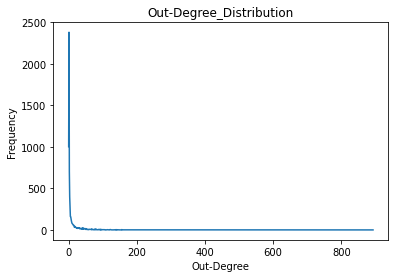

In [86]:
plot_distribution(out_degree_distribution, "Out-Degree", "Frequency", "Out-Degree_Distribution", save=True)

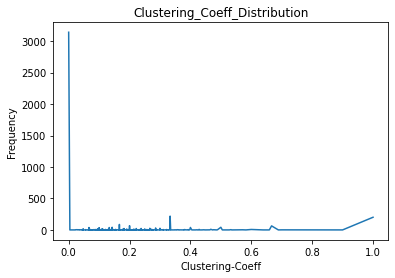

In [87]:
plot_distribution(clustering_coeff_distribution, "Clustering-Coeff", "Frequency", "Clustering_Coeff_Distribution", save=True)